# Imports

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import chess
from torchsummary import summary
import numpy as np
import random
from tqdm.notebook import tqdm
import chess.svg
import cairosvg

# Device

In [113]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"✅ {device_count} CUDA device(s) available:")
    for i in range(device_count):
        print(f"  └─ [{i}] {torch.cuda.get_device_name(i)}")
    DEVICE = torch.device("cuda")
else:
    print("⚠️ CUDA not available, using CPU.")
    DEVICE = torch.device("cpu")

✅ 1 CUDA device(s) available:
  └─ [0] NVIDIA GeForce GTX 1650


# Encoding

In [135]:

def board_encoder(board: chess.Board) -> np.ndarray:
    planes = np.zeros((19, 8, 8), dtype=np.float32)
    piece_map = board.piece_map()

    # 12 planes for pieces (6x2)
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        plane_idx = (piece.piece_type - 1) + \
            (0 if piece.color == chess.WHITE else 6)
        planes[plane_idx][row][col] = 1

    # Turn to move
    planes[12].fill(float(board.turn))

    # Castling rights (4 planes)
    planes[13].fill(board.has_kingside_castling_rights(chess.WHITE))
    planes[14].fill(board.has_queenside_castling_rights(chess.WHITE))
    planes[15].fill(board.has_kingside_castling_rights(chess.BLACK))
    planes[16].fill(board.has_queenside_castling_rights(chess.BLACK))

    # Halfmove clock (normalized)
    planes[17].fill(board.halfmove_clock / 100.0)

    # En Passant square (new plane!)
    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        planes[18][row][col] = 1.0

    return planes


def move_to_index(move: chess.Move) -> int:
    from_square = move.from_square
    to_square = move.to_square
    promotion = move.promotion

    dx = chess.square_file(to_square) - chess.square_file(from_square)
    dy = chess.square_rank(to_square) - chess.square_rank(from_square)

    # Handle knight moves separately
    knight_deltas = {(1, 2): 0, (2, 1): 1, (2, -1): 2, (1, -2):3,
                     (-1, -2): 4, (-2, -1): 5, (-2, 1): 6, (-1, 2): 7}
    if (dx, dy) in knight_deltas:
        dir_idx = knight_deltas[(dx, dy)]
        return from_square * 73 + 56 + dir_idx

    # Handle promotions
    if promotion is not None:
        promo_types = [chess.KNIGHT, chess.ROOK, chess.BISHOP]
        directions = [-1, 0, 1]  # left, straight, right
        dx = chess.square_file(to_square) - chess.square_file(from_square)

        if dx in directions and promotion in promo_types:
            dir_idx = directions.index(dx)
            promo_idx = promo_types.index(promotion)
            return from_square * 73 + 64 + (promo_idx * 3) + dir_idx

    # Handle normal directional moves
    directions = {(0, 1): 0, (1, 0): 1, (0, -1): 2, (-1, 0): 3,
                  (1, 1): 4, (1, -1): 5, (-1, 1): 6, (-1, -1): 7}
    curr_dir = [0, 0]
    if dx > 0: curr_dir[0] = 1
    if dx < 0: curr_dir[0] = -1
    if dy > 0: curr_dir[1] = 1
    if dy < 0: curr_dir[1] = -1
    curr_dir = tuple(curr_dir)
    diff = abs(dx) | abs(dy)
    assert diff > 0

    if curr_dir in directions:
        dir_index = directions[curr_dir]
        return from_square * 73 + (diff-1)*8 + dir_index

    raise ValueError(f"Move {move} could not be encoded.")


def index_to_move(index: int) -> chess.Move:
    from_square = index // 73
    sub_index = index % 73

    if sub_index < 56:
        # Sliding move
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        diff, dir = sub_index // 8, sub_index%8
        diff += 1
        dx, dy = ( diff*directions[dir][0], diff*directions[dir][1] )
        fx = chess.square_file(from_square)
        fy = chess.square_rank(from_square)
        tx = fx + dx
        ty = fy + dy
        if 0 <= tx < 8 and 0 <= ty < 8:
            to_square = chess.square(tx, ty)
            move = chess.Move(from_square, to_square)
            return move

    elif sub_index < 64:
        # Knight move
        knight_deltas = [(1, 2), (2, 1), (2, -1), (1, -2),
                         (-1, -2), (-2, -1), (-2, 1), (-1, 2)]
        dx, dy = knight_deltas[sub_index - 56]
        fx = chess.square_file(from_square)
        fy = chess.square_rank(from_square)
        tx = fx + dx
        ty = fy + dy
        if 0 <= tx < 8 and 0 <= ty < 8:
            to_square = chess.square(tx, ty)
            move = chess.Move(from_square, to_square)
            return move

    else:
        # Promotion
        promo_idx = sub_index - 64
        promotion_types = [chess.KNIGHT, chess.ROOK, chess.BISHOP]
        directions = [-1, 0, 1]
        promo_type = promotion_types[promo_idx // 3]
        dx = directions[promo_idx % 3]

        fx = chess.square_file(from_square)
        fy = chess.square_rank(from_square)
        tx = fx + dx
        if fy == 6:
            ty = 7
        elif fy == 1:
            ty = 0
        else:
            raise ValueError("Not a valid promotion square")

        if 0 <= tx < 8 and 0 <= ty < 8:
            to_square = chess.square(tx, ty)
            move = chess.Move(from_square, to_square, promotion=promo_type)
            return move

    raise ValueError(f"Index {index} could not be decoded to a legal move.")


TOTAL_MOVES = 4672
index_move_map, move_index_map = {}, {}
for id in range(TOTAL_MOVES+1):
    try:
        index_move_map[id] = index_to_move(id)
    except:
        continue
for _, move in index_move_map.items():
    id = move_to_index(move)
    move_index_map[move] = id
    curr_uci = move.uci()
    # Queen promotion maps to native
    if curr_uci[-1] =='1' or curr_uci[-1] == '8':
        move_index_map[chess.Move.from_uci(curr_uci+'q')] = id
len(index_move_map), len(move_index_map)

(1924, 2312)

# Model

In [136]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class ChessNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_conv = nn.Conv2d(19, 64, kernel_size=3, padding=1)
        self.bn_input = nn.BatchNorm2d(64)

        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(5)])

        # Policy head
        self.policy_conv = nn.Conv2d(64, 2, kernel_size=1)
        self.policy_bn = nn.BatchNorm2d(2)
        self.policy_fc = nn.Linear(2 * 8 * 8, 4672)

        # Value head
        self.value_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(8 * 8, 64)
        self.value_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn_input(self.input_conv(x)))
        x = self.res_blocks(x)

        # Policy head
        p = F.relu(self.policy_bn(self.policy_conv(x)))
        p = p.view(p.size(0), -1)
        p = self.policy_fc(p)

        # Value head
        v = F.relu(self.value_bn(self.value_conv(x)))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        v = torch.tanh(self.value_fc2(v))

        return p, v


# Instantiate and print summary
model = ChessNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary for input size [batch_size=1, 19, 8, 8]
summary(model, input_size=(19, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]          11,008
       BatchNorm2d-2             [-1, 64, 8, 8]             128
            Conv2d-3             [-1, 64, 8, 8]          36,928
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
     ResidualBlock-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
           Conv2d-10             [-1, 64, 8, 8]          36,928
      BatchNorm2d-11             [-1, 64, 8, 8]             128
    ResidualBlock-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
      BatchNorm2d-14             [-1, 6

# MCTS Search

In [137]:
import numpy as np
import math
import chess


class MCTSNode:
    def __init__(self, board: chess.Board, parent=None, move=None):
        self.board = board
        self.parent = parent
        self.move = move
        self.children = {}
        self.visit_count = 0
        self.total_value = 0.0
        self.prior = 0.0

    def is_expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.total_value / self.visit_count

def softmax_temperature(logits, temperature=1.0):
    logits = np.array(logits, dtype=np.float32)
    logits = logits / temperature
    logits = logits - np.max(logits)
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits)

def select_child(node, c_puct=1.0):
    best_score = -float('inf')
    best_move = None
    best_child = None

    for move, child in node.children.items():
        ucb = child.value() + c_puct * child.prior * \
            math.sqrt(node.visit_count) / (1 + child.visit_count)
        if ucb > best_score:
            best_score = ucb
            best_move = move
            best_child = child
    return best_move, best_child

def expand_node(node, policy_logits, legal_moves):
    legal_indices = [move_index_map[move] for move in legal_moves]
    masked_logits = np.full_like(policy_logits, -np.inf)
    for idx in legal_indices:
        masked_logits[idx] = policy_logits[idx]

    probs = softmax_temperature(masked_logits)
    for move in legal_moves:
        index = move_index_map[move]
        prior = probs[index]
        next_board = node.board.copy()
        next_board.push(move)
        child = MCTSNode(next_board, parent=node, move=move)
        child.prior = prior
        node.children[move] = child

def backpropagate(node, value):
    while node:
        node.visit_count += 1
        node.total_value += value
        node = node.parent
        value = -value

def mcts_search(board, model, num_simulations=800):
    root = MCTSNode(board)
    board_input = board_encoder(board)
    board_input = torch.tensor(board_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        policy_logits, value = model(board_input)
        policy_logits = policy_logits[0].cpu().numpy()
        value = float(value[0].item())

    legal_moves = list(board.legal_moves)
    expand_node(root, policy_logits, legal_moves)

    for _ in range(num_simulations):
        node = root
        search_path = [node]

        while node.is_expanded():
            move, node = select_child(node)
            search_path.append(node)

        board_input = board_encoder(node.board)
        board_input = torch.tensor(
            board_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            policy_logits, value = model(board_input)
            policy_logits = policy_logits[0].cpu().numpy()
            value = float(value[0].item())

        legal_moves = list(node.board.legal_moves)
        expand_node(node, policy_logits, legal_moves)

        backpropagate(node, value)

    return root

def choose_action(root, temperature=1.0):
    visit_counts = np.array(
        [child.visit_count for child in root.children.values()])
    moves = list(root.children.keys())

    if temperature == 0:
        best_move = moves[np.argmax(visit_counts)]
        return best_move

    probs = softmax_temperature(visit_counts, temperature)
    return np.random.choice(moves, p=probs)

# Self Play

In [142]:
def play_self_play_game(model, num_simulations=100):
    board = chess.Board()
    states = []
    policies = []
    outcomes = []

    i = 0
    while not board.is_game_over():
        root = mcts_search(board, model, num_simulations)
        move = choose_action(root, temperature=1.0)

        # Record data
        board_tensor = board_encoder(board)
        visit_counts = np.array([child.visit_count for child in root.children.values()])
        visit_sum = np.sum(visit_counts)
        policy_target = np.zeros(TOTAL_MOVES)
        for m, child in root.children.items():
            idx = move_index_map[m]
            policy_target[idx] = child.visit_count / visit_sum

        states.append(board_tensor)
        policies.append(policy_target)
        board.push(move)

        svg = chess.svg.board(board=board)
        cairosvg.svg2png(bytestring=svg.encode('utf-8'), write_to='temp.jpg')

        i += 1
        print( f"Finished Move: {i}" )

    result = board.result()
    if result == '1-0':
        z = 1
    elif result == '0-1':
        z = -1
    else:
        z = 0

    # Assign outcomes for all steps
    for i in range(len(states)):
        outcomes.append(z if (i % 2 == 0) else -z)

    return states, policies, outcomes

# Collect Data

In [ ]:
def generate_training_data(model, num_games=10):
    all_states = []
    all_policies = []
    all_values = []

    for _ in tqdm(range(num_games)):
        states, policies, values = play_self_play_game(model)
        all_states.extend(states)
        all_policies.extend(policies)
        all_values.extend(values)

    return np.array(all_states), np.array(all_policies), np.array(all_values)

all_states, all_policies, all_values = generate_training_data(model)

  0%|          | 0/10 [00:00<?, ?it/s]

Finished Move: 1
Finished Move: 2
Finished Move: 3
Finished Move: 4
Finished Move: 5
Finished Move: 6
Finished Move: 7
Finished Move: 8
Finished Move: 9
Finished Move: 10
Finished Move: 11
Finished Move: 12
Finished Move: 13
Finished Move: 14
Finished Move: 15
Finished Move: 16
Finished Move: 17
Finished Move: 18
Finished Move: 19
Finished Move: 20
Finished Move: 21
Finished Move: 22
Finished Move: 23
Finished Move: 24
Finished Move: 25
Finished Move: 26
Finished Move: 27
Finished Move: 28
Finished Move: 29
Finished Move: 30
Finished Move: 31
Finished Move: 32
Finished Move: 33
Finished Move: 34
Finished Move: 35
Finished Move: 36
Finished Move: 37
Finished Move: 38
Finished Move: 39
Finished Move: 40
Finished Move: 41
Finished Move: 42
Finished Move: 43
Finished Move: 44
Finished Move: 45
Finished Move: 46
Finished Move: 47
Finished Move: 48
Finished Move: 49
Finished Move: 50
Finished Move: 51
Finished Move: 52
Finished Move: 53
Finished Move: 54
Finished Move: 55
Finished Move: 56
F

/tmp/ipykernel_102842/2575618511.py:27: RuntimeWarning: invalid value encountered in subtract
  logits = logits - np.max(logits)


Finished Move: 110
Finished Move: 111
Finished Move: 112
Finished Move: 113
Finished Move: 1
Finished Move: 2
Finished Move: 3
Finished Move: 4
Finished Move: 5
Finished Move: 6
Finished Move: 7
Finished Move: 8
Finished Move: 9
Finished Move: 10
Finished Move: 11
Finished Move: 12
Finished Move: 13
Finished Move: 14
Finished Move: 15
Finished Move: 16
Finished Move: 17
Finished Move: 18
Finished Move: 19
Finished Move: 20
Finished Move: 21
Finished Move: 22
Finished Move: 23
Finished Move: 24
Finished Move: 25
Finished Move: 26
Finished Move: 27
Finished Move: 28
Finished Move: 29
Finished Move: 30
Finished Move: 31
Finished Move: 32
Finished Move: 33
Finished Move: 34
Finished Move: 35
Finished Move: 36
Finished Move: 37
Finished Move: 38
Finished Move: 39
Finished Move: 40
Finished Move: 41
Finished Move: 42
Finished Move: 43
Finished Move: 44
Finished Move: 45
Finished Move: 46
Finished Move: 47
Finished Move: 48
Finished Move: 49
Finished Move: 50
Finished Move: 51
Finished Move: 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7440250bcce0>>
Traceback (most recent call last):
  File "/home/mystic/Programming/mystic-bot/.env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Finished Move: 456
Finished Move: 457
Finished Move: 458
Finished Move: 459
Finished Move: 460
Finished Move: 461
Finished Move: 462
Finished Move: 463
Finished Move: 464
Finished Move: 465
Finished Move: 466
Finished Move: 467
Finished Move: 468
Finished Move: 469
Finished Move: 470
Finished Move: 471
Finished Move: 472
Finished Move: 473


# Train the model

In [ ]:
def train_model(model, X, P, Z, epochs=10, batch_size=64, device="cpu"):
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn_policy = torch.nn.CrossEntropyLoss()
    loss_fn_value = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X, P, Z)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for xb, pb, zb in loader:
            xb, pb, zb = xb.to(device), pb.to(device), zb.to(device)

            pred_policy, pred_value = model(xb)
            loss_p = loss_fn_policy(pred_policy, torch.argmax(pb, dim=1))
            loss_v = loss_fn_value(pred_value.squeeze(), zb)
            loss = loss_p + loss_v

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")

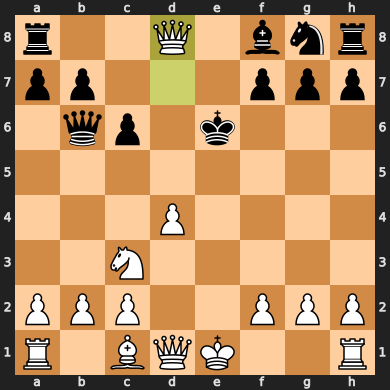

In [132]:
board = chess.Board("r4bnr/pp1P1ppp/1qp1k3/8/3P4/2N5/PPP2PPP/R1BQK2R w KQ - 2 11")
board.push(chess.Move.from_uci('d7d8q'))
board